## Y-Net on synthetic dataset

In [1]:
# !pip install Shapely
# !pip install imutils

In [2]:
import json
import os
import numpy as np
np.random.seed(42)
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.colors import NoNorm
import random
import PIL
from PIL import Image
import argparse
import imutils
from skimage.morphology import convex_hull_image, watershed
from skimage import data, img_as_float
from skimage.util import invert
from skimage.io import imsave
import contextlib
import math
from skimage import io
from tqdm import tqdm
import time
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon, Point
import pandas as pd
from sklearn import metrics
from skimage.feature import peak_local_max
from scipy import ndimage
from tqdm.notebook import tqdm
from copy import deepcopy
import seaborn as sns
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=2)
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import CustomObjectScope
from keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
#turn off tf warnings
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


### Set GPU

In [5]:
# Specify which GPU(s) to us3
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
# On CPU/GPU placement
config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1b.0, compute capability: 7.0



### Set visualization functions

In [3]:
# Display data 
def show_images3 (Im1, Im2, Im3, title1="", title2 = "", title3 = ""):
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    axis1 = fig.add_subplot(131)
    axis1.imshow(Im1, cmap="gray")
    axis1.set(xticks=[],yticks=[],title =title1)

    axis2 = fig.add_subplot(132)
    axis2.imshow(Im2, cmap="gray")
    axis2.set(xticks=[],yticks=[],title =title2)
    
    axis2 = fig.add_subplot(133)
    axis2.imshow(Im3, cmap="gray")
    axis2.set(xticks=[],yticks=[],title =title3)
    
def show_images3_heatmap (Im1, Im2, Im3, title1="", title2 = "", title3 = ""):
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    axis1 = fig.add_subplot(131)
    axis1.imshow(Im1, cmap="hot")
    axis1.set(xticks=[],yticks=[],title =title1)

    axis2 = fig.add_subplot(132)
    axis2.imshow(Im2, cmap="hot")
    axis2.set(xticks=[],yticks=[],title =title2)
    
    axis2 = fig.add_subplot(133)
    axis2.imshow(Im3, cmap="hot")
    axis2.set(xticks=[],yticks=[],title =title3)
    
    
def show_images2 (Im1, Im2, title1="", title2 = ""):
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    axis1 = fig.add_subplot(121)
    axis1.imshow(Im1, cmap="gray")
    axis1.set(xticks=[],yticks=[],title =title1)

    axis2 = fig.add_subplot(122)
    axis2.imshow(Im2, cmap="gray")
    axis2.set(xticks=[],yticks=[],title =title2)
    
def show_images2_heatmap (Im1, Im2, title1="", title2 = ""):
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    axis1 = fig.add_subplot(121)
    axis1.imshow(Im1, cmap="hot")
    axis1.set(xticks=[],yticks=[],title =title1)

    axis2 = fig.add_subplot(122)
    axis2.imshow(Im2, cmap="hot")
    axis2.set(xticks=[],yticks=[],title =title2)
    
    
def show_images2_overlayed (Im1, Im1_mask, Im2, Im2_mask, Im3,Im3_mask, title1="", title2 = "", title3 = ""):
    a = 0.5 #transparency parameter
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    axis1 = fig.add_subplot(131)
    axis1.imshow(Im1, cmap="gray")
    axis1.imshow(Im1_mask,alpha=a)
    axis1.set(xticks=[],yticks=[],title =title1)

    axis2 = fig.add_subplot(132)
    axis2.imshow(Im2, cmap="gray")
    axis2.imshow(Im2_mask, alpha =a)
    axis2.set(xticks=[],yticks=[],title =title2)
    
    axis2 = fig.add_subplot(133)
    axis2.imshow(Im3, cmap="gray")
    axis2.imshow(Im3_mask, alpha = a)
    axis2.set(xticks=[],yticks=[],title =title3)
    
    
def show_images1_overlayed (Im1, Im1_mask, title1=""):
    a = 0.5 #transparency parameter
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    plt.imshow(Im1, cmap="gray")
    plt.imshow(Im1_mask,alpha=a)
    #axis1.set(xticks=[],yticks=[],title =title1)

    
def show_images1 (Im1, title1=""):
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    plt.imshow(Im1, cmap="gray")
    plt.xticks=[]
    plt.yticks=[]
    plt.title =title1
    
def show_images1_heatmap (Im1, title1=""):
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    plt.imshow(Im1, cmap="hot")
    plt.xticks=[]
    plt.yticks=[]
    plt.title =title1

### Y-NET Prediction

In [1]:
IM_SIZE = 400
y_out_test_thresh = np.zeros(shape = [l_roi_test, IM_SIZE, IM_SIZE])
for i in range(l_roi_test):
    ret, temp = cv.threshold((np.squeeze(y_out_test[i,:,:]*255).astype(np.uint8)).copy(),
                             0, 255,cv.THRESH_OTSU+cv.THRESH_BINARY)
    #y_out_test_thresh[i, :, :] =cv.medianBlur(temp, 7)
    y_out_test_thresh[i, :, :] = temp#closed#

NameError: name 'np' is not defined

NameError: name 'np' is not defined

NameError: name 'np' is not defined

NameError: name 'np' is not defined

NameError: name 'np' is not defined

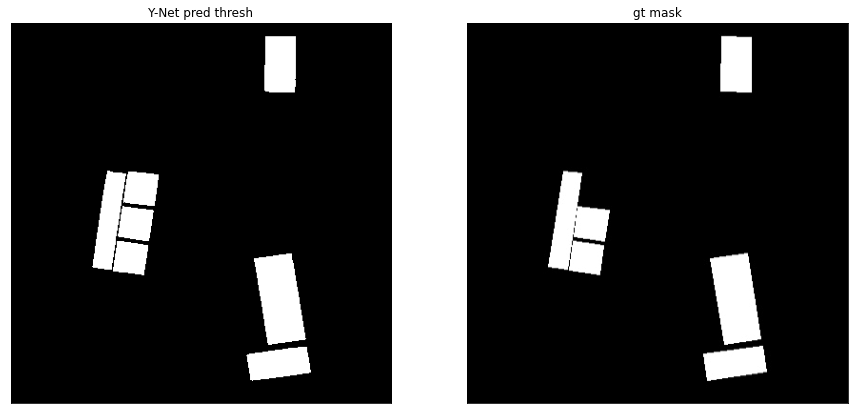

In [11]:
g =random.randint(0, l_roi_test)
#im_test = np.squeeze(y_out_test_thresh[g,:,:])
show_images2(np.squeeze(y_out_test_thresh[g,:,:]), 
             np.squeeze(y_gth_test[g,:,:]), 
             title1 = 'Y-Net pred thresh', 
             title2 = 'gt mask')

In [4]:
from sklearn.metrics import precision_recall_curve
import pprint
pp = pprint.PrettyPrinter(indent=2)

In [5]:
def Reverse(lst): 
    return [ele for ele in reversed(lst)]

In [6]:
def normalize_to_gray(im):
    if len(im.shape) > 2:
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        _, im = cv.threshold(((im*255).astype(np.uint8)).copy(),0 ,255 ,cv.THRESH_OTSU+cv.THRESH_BINARY)
    im = im / im.max()
    return im 

In [7]:
def findBoundingboxss(image, correction_margin=0):
    #print('A')
    ##################### no trans#############################
    #contours, _ = cv.findContours(image.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    ##################### morph trans #########################
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    closed = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
    closed = cv.erode(closed, None, iterations = 3)
    contours, _ = cv.findContours(closed.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    ##################### Watershed ############################
    #_, imgray = cv.threshold(closed, 0, 255, cv.THRESH_BINARY)
#     closed = image
#     #t=time.time()
#     Distance = ndimage.distance_transform_edt(closed)
#     D = ((Distance - Distance.min()) / (Distance.max() - Distance.min()) * 255).astype(np.uint8)
#     _, D = cv.threshold(D, 0, 255, cv.THRESH_BINARY)
#     localMax = peak_local_max(D, indices=False, min_distance=1, labels=closed)
#     markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
#     labels = watershed(-D, markers, mask=closed)
#     boundingBoxs = []
#     scores = []
#     for i in range(1, labels.max()+1):
#         mask_temp = np.where(labels==i, np.uint8(255), np.uint8(0))
#         contours, _ = cv.findContours(mask_temp.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
#         for contour in contours:
#             rect = cv.minAreaRect(contour)
#             poly = cv.boxPoints(rect)
#             box = np.int0(poly)
#             boundingBoxs.append(box)
#             scores.append(get_confidence_score(image, box))
#     #print(t-time.time())
#     return boundingBoxs, scores
# comment up to watershed and uncomment bellow as it is
    #contours, _ = cv.findContours(closed.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    boundingBoxs = []
    scores = []
    for contour in contours:
        rect = cv.minAreaRect(contour)
        ############ polygone bboxes ##############
        poly = cv.boxPoints(rect)
        box = np.int0(poly)
        #boundingBoxs.append(box)
        ############ Up Right bboxes ##############
        x, y, w, h = cv.boundingRect(contour)
        temp = [y - correction_margin, x - correction_margin, y + h + correction_margin, x + w + correction_margin]
        boundingBoxs.append(temp)
        scores.append(get_confidence_score_(image, box))    
    return boundingBoxs, scores

In [8]:
def get_confidence_score_(im_mask, bb):
    cnt = 0
    pixel_acc = 0
    im_w = im_mask.shape[0]
    im_h = im_mask.shape[1]
    poly = Polygon(bb)
    minx, miny, maxx, maxy = list(np.int_(poly.bounds))
    for row in range(minx, min( 400, maxx)):
        for col in range(miny, min(400, maxy)):
            p_temp = Point(row, col)
            if p_temp.within(poly):
                cnt += 1
                pixel_acc = pixel_acc + im_mask[col, row]#/im_mask.max()
    if cnt == 0:
        return 0
    avg_pix_value = pixel_acc/cnt
    return avg_pix_value

In [9]:
def calc_iou_individual(pred_box, gt_box):

    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

#     if (x1_p > x2_p) or (y1_p > y2_p):
#         raise AssertionError(
#             "Prediction box is malformed? pred box: {}".format(pred_box))
#     if (x1_t > x2_t) or (y1_t > y2_t):
#         raise AssertionError(
#             "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

In [10]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        #print('A')
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        #pp.pprint({'true_pos': tp, 'false_pos': fp, 'false_neg': fn})
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        #print('B')
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        #pp.pprint({'true_pos': tp, 'false_pos': fp, 'false_neg': fn})
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
            #print(iou)
    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        #print('C')
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        #print('D')
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    #pp.pprint({'true_pos': tp, 'false_pos': fp, 'false_neg': fn})
    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

In [11]:
def calc_precision_recall(img_results):

    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

In [12]:
def get_model_scores_map(pred_boxes):

    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [13]:
def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):

    model_scores_map = get_model_scores_map(pred_boxes)
    #print(model_scores_map)
#     #print(model_scores_map)
    sorted_model_scores = sorted(model_scores_map.keys())
    #print(sorted_model_scores)
    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    #cnt = 1
    #for ithr, model_score_thr in enumerate(sorted_model_scores):#pred_boxes[img_id]['scores']
     #   cnt +=1
        # On first iteration, define img_results for the first time:
    img_ids = gt_boxes.keys() #if ithr == 0 else model_scores_map[model_score_thr]
    for img_id in img_ids:
        #cnt +=1
        gt_boxes_img = gt_boxes[img_id]
        pred_boxes_img = pred_boxes_pruned[img_id]['boxes']
        # calculate image results for this image
        img_results[img_id] = get_single_image_results(
            gt_boxes_img, pred_boxes_img, iou_thr)
        #pp.pprint(img_results)
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        #print('r and p for up to image i')
        #print(prec, rec)
    #pp.pprint(img_results)

    precisions = np.array(precisions)

    recalls = np.array(recalls)
    #print('########')
    #print('r array')
    #print(precisions)
    #print('p array')
    #print(recalls)

    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)
    #print('#####')
    #print('ap')
    #x = np.linspace(0.0, 1.0, 11)
    #print(prec_at_rec)
    #print(precisions)
    #print(recalls)
    #print(x)
    #precision_recall_curve()

    #print('last r p array el')
    #print(precisions[len(precisions)-1], recalls[len(recalls)-1])
    #print('prec at rec')
    #print(prec_at_rec)
    #plt.plot(np.linspace(0.0, 1.0, 11), prec_at_rec)

    #print('args')
    #print(args)
    #plt.plot(args, prec_at_rec)
    #plt.plot(x, precisions)
    #plt.plot(x, prec_at_rec)
    #plt.plot(recalls, Reverse(precisions))
    #print(len(precisions))
    #print(len(recalls))
#     p =[]
#     r = []
#     for y in range(len(precisions)):
#         p.append(pr)
#         precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
#                                                         y_score[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

#     interpolation = list(precisions)
#     for i in reversed(range(len(interpolation) - 1)):
#         if interpolation[i+1]>interpolation[i]:
#             interpolation[i]=interpolation[i+1]
#     plt.plot(list(recalls), interpolation)
    #plt.legend(t, title = 'iou thresholds', loc='lower right')
    #AP.append(metrics.auc(list(data["Recall"]), interpolation))
    #return {'avg_prec': avg_prec}
    #return avg_prec, prec_at_rec, precisions, recalls
    return {
            'avg_prec': avg_prec,
            'precisions': precisions,
            'recalls': recalls,
            }

In [14]:
def get_avg_precision_at_iou2(gt_boxes, pred_boxes, iou_thr=0.5):

    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
#             start_idx = 0
#             for score in box_scores:
#                 if score <= model_score_thr:
#                     pred_boxes_pruned[img_id]
#                     start_idx += 1
#                 else:
#                     break

#             # Remove boxes, scores of lower than threshold scores:
#             pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
#             pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)
        
            prec, rec = calc_precision_recall(img_results)
            precisions.append(prec)
            recalls.append(rec)
            model_thrs.append(model_score_thr)
    #pp.pprint(img_results)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [15]:
def get

In [16]:
def result_dict_pred(predictions, findBoundingBoxss=findBoundingboxss,  threshold=0.5, correction_margin=0):
    k = 0
    pred_boxs = {}
    for prediction in tqdm(predictions):
        prediction = (normalize_to_gray(prediction) > threshold).astype(np.uint8)
#         plt.figure()
#         plt.imshow(prediction)
        ##find bounding boxes and conf score
        bbs_pred, confidences = findBoundingBoxss(prediction, correction_margin)
#         pp.pprint(bbs_pred)
#         print('')
#         print(confidences)
        #Pred Boxes dict
        pred_boxs["img_{:d}".format(k)]= {"boxes": bbs_pred, "scores": confidences}
        k+=1
    return pred_boxs


In [38]:
def result_dict_gt(start, end):
    
    n_box = len(x_min)
    temp = []
    for i_box in range(n_box):
        temp.append([int(y_min[i_box]), int(x_min[i_box]), int(y_max[i_box]), int(x_max[i_box])])
    ground_truth_['img_{:d}'.format(k)] = temp
    k+=1
    return ground_truth_

In [27]:
start_idx = 0
end_idx = 50

In [28]:
predictions = []
for i in range(start_idx, end_idx+1):
    predicition = np.squeeze(y_out_test_thresh[i,:,:])
    predictions.append(predicition)

In [29]:
# d = result_dict_gt(start_idx, end_idx+1)
# pp.pprint(d)

In [30]:
# dd = result_dict_pred(predictions, findBoundingBoxss=findBoundingboxss, threshold=0.5)
# pp.pprint(dd)

In [48]:
def get

In [49]:
gt_boxes_dict = result_dict_gt(start_idx, end_idx+1)

In [50]:
# print('predictions')
# pp.pprint(pred_boxes_dict)
# print('#######################################################################')
# print('ground thuth')
# print('')
# pp.pprint(gt_boxes_dict)

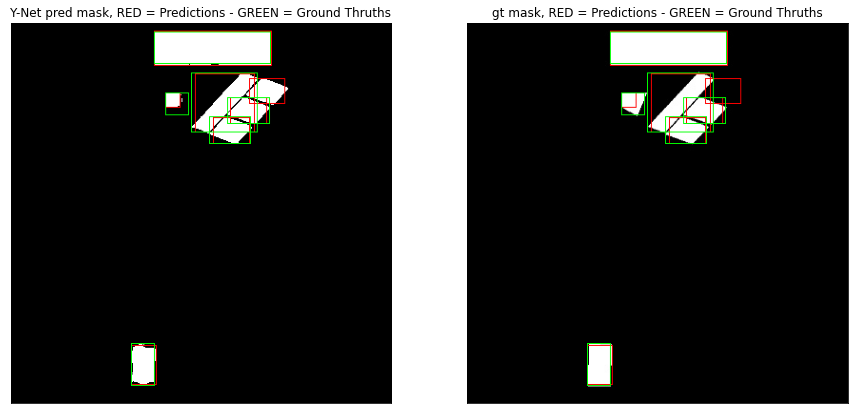

In [81]:
#visual check 
target_image_idx = 3#np.random.randint(start_idx, end_idx)
#pp.pprint(pred_boxes_dict['img_{:d}'.format(target_image_idx)])
pred_bboxes_coord = pred_boxes_dict['img_{:d}'.format(target_image_idx)]['boxes']
pred_bboxes_scores = pred_boxes_dict['img_{:d}'.format(target_image_idx)]['scores']
gt_bboxes_coord = gt_boxes_dict['img_{:d}'.format(target_image_idx)]

xx = (np.squeeze(y_gth_test[target_image_idx,:,:]).astype(np.uint8)).copy()
xx = cv.cvtColor(xx, cv.COLOR_GRAY2RGB)
xx_pred = (np.squeeze(y_out_test_thresh[target_image_idx,:,:]).astype(np.uint8)).copy()
xx_pred = cv.cvtColor(xx_pred, cv.COLOR_GRAY2RGB)
for bbox_pred in pred_bboxes_coord:
    cv.rectangle(xx, (bbox_pred[1], bbox_pred[0], bbox_pred[3]-bbox_pred[1], bbox_pred[2]-bbox_pred[0]), (255, 0, 0), 1)
    cv.rectangle(xx_pred, (bbox_pred[1], bbox_pred[0], bbox_pred[3]-bbox_pred[1], bbox_pred[2]-bbox_pred[0]), (255, 0, 0), 1)
for bbox_gt in gt_bboxes_coord:
    cv.rectangle(xx, (bbox_gt[1], bbox_gt[0], bbox_gt[3]-bbox_gt[1], bbox_gt[2]-bbox_gt[0]), (0, 255, 0), 1)
    cv.rectangle(xx_pred, (bbox_gt[1], bbox_gt[0], bbox_gt[3]-bbox_gt[1], bbox_gt[2]-bbox_gt[0]), (0, 255, 0), 1)
    
show_images2(xx_pred, 
             xx, 
             title1='Y-Net pred mask, RED = Predictions - GREEN = Ground Thruths', 
             title2 = 'gt mask, RED = Predictions - GREEN = Ground Thruths')


In [80]:
# #p = tp/(tp+fp)
# #r = tp/(tp+fn)

results = get_avg_precision_at_iou3(gt_boxes_dict, pred_boxes_dict, iou_thr=0.9)
ap = results['avg_prec']
p = results['precisions']
r = results ['recalls']

print('AP = ', ap)
print('prec = ', p[-1])
print('rec = ', r[-1])

AP =  0.1443745383224229
prec =  0.39634146341463417
rec =  0.2927927927927928


In [2141]:
threshold=0.5
iou_threshold=0.5

total_num_GT = 0
all_data = {"confidenceScore": [], "iou": []}
all_amazon_json = glob.glob("/home/ec2-user/SageMaker/benchmarks/amazon_images/all/*.json")
for i, filename in tqdm(enumerate(all_amazon_json), total=len(all_amazon_json)):
    with open(filename,) as f:
        gt = json.load(f)
    bbs_truth = [shape['points'] for shape in gt['shapes']]
    img_name = os.path.basename(filename)[:-4] + 'jpg'
    loadpath = "./amazon_test/"+img_name
    img = cv2.imread(loadpath)
    if img is None:
        continue

    prediction = (normalize_to_gray(img) > threshold).astype(np.uint8)
    # find bounding boxes
    bbs_pred, confidences = findBoundingboxs(prediction)
        
    for bb_truth in bbs_truth:
        max_iou = 0
        max_cs = 0
        for i in range(len(bbs_pred)):
            curr_iou = iou(bbs_pred[i], bb_truth)
            if curr_iou > max_iou:
                max_iou = curr_iou
                max_cs = confidences[i]
        all_data["iou"].append(max_iou)
        all_data["confidenceScore"].append(max_cs)

    # increment total ground truths count
    total_num_GT += len(bbs_truth)

In [1965]:
# #GT Boxes
# gt_boxes_dict1= {"img_00285.png": [[480, 457, 515, 529], [637, 435, 676, 536]]}
# #Pred Boxes
# pred_boxs_dict1={"img_00285.png": {"boxes": [[330, 463, 387, 505], [356, 456, 391, 521], [420, 433, 451, 498], [328, 465, 403, 540], [480, 477, 508, 522], 
#                                        [357, 460, 417, 537], [344, 459, 389, 493], [485, 459, 503, 511], [336, 463, 362, 496], [468, 435, 520, 521], 
#                                        [357, 458, 382, 485], [649, 479, 670, 531], [484, 455, 514, 519], [641, 439, 670, 532]], 
#                              "scores": [0.0739, 0.0843, 0.091, 0.1008, 0.1012, 0.1058, 0.1243, 0.1266, 0.1342, 0.1618, 0.2452, 0.8505, 0.9113, 0.972]}}

In [1791]:
# ###2k ap50

# (5, 5)+ 1 iteration + margin= 2

# 50
# AP =  0.7679387843495836
# prec =  0.9385918475383801
# rec =  0.8947368421052632


# 90
# AP =  0.06818181818181818
# prec =  0.25
# rec =  0.2631578947368421
# #######################################################

# (5, 5)+ 2 iteration + margin= 4
# 50
# AP =  0.8532537777021812
# prec =  0.9387113672079623
# rec =  0.9030453697949037


# 90
# AP =  0.06818181818181818
# prec =  0.25
# rec =  0.2631578947368421

# #######################################################
# (3, 3)+ 2 iteration + margin= 4
# 50
# AP =  0.8532537777021812
# prec =  0.9387113672079623
# rec =  0.9030453697949037 

# 90
# AP =  0.06818181818181818
# prec =  0.25
# rec =  0.2631578947368421

# #######################################################

# (3, 3)+ 1 iteration + margin= 3
# 50

# AP =  0.7549203373945642
# prec =  0.9226804123711341
# rec =  0.8879892037786775


# 90
# AP =  0.017771144910509216
# prec =  0.10024449877750612
# rec =  0.10526315789473684

# #######################################################

# (5, 5) + 3 iterations + correction margin 4
# 50
# AP =  0.8853180647066115
# prec =  0.9750145264381174
# rec =  0.8402603905858789
# 90

# AP =  0.21703758135628803
# prec =  0.4758861127251598
# rec =  0.4101151727591387


# plt.figure(figsize=(15,5))
# plt.plot(Reverse(sorted(r)), sorted(p))

SyntaxError: invalid syntax (<ipython-input-1791-86001aa24e56>, line 3)

In [1750]:
# print(p[:4])
# print(r[:4])

[0.57142857 0.66666667 0.76923077 0.75      ]
[0.57142857 0.66666667 0.76923077 0.78947368]


Text(0, 0.5, 'precision')

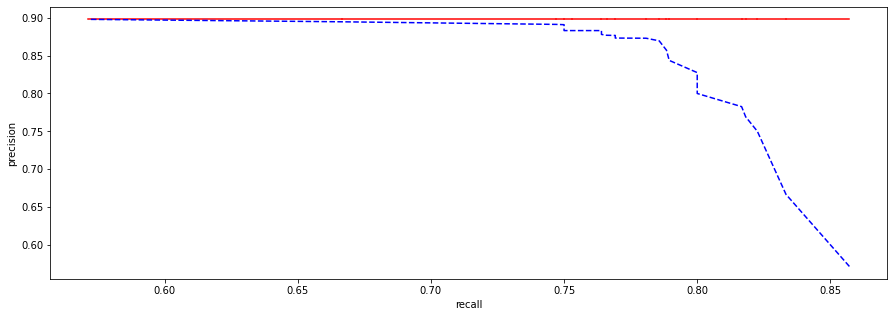

In [1944]:
#just a dummy sample
#recall=np.linspace(0.0,1.0,num=42)
#precision=np.random.rand(42)*(1.-recall)
recall=np.array(Reverse(sorted(r)))#np.linspace(0.0,1.0,num=2000)
i=recall.shape[0]-2
precision = np.array(sorted(p))#p#*(1.-recall)
precision2=precision.copy()

#print(len(precision))
#print(len(recall))
#plt.figure(figsize=(15,5))
# interpolation...
while i>=0:
    if precision[i+1]>precision[i]:
        precision[i]=precision[i+1]
    i=i-1

# plotting...
fig, ax = plt.subplots(figsize=(15,5))
for i in range(recall.shape[0]-1):
    ax.plot((recall[i],recall[i]),(precision[i],precision[i+1]),'k-',label='',color='red') #vertical
    ax.plot((recall[i],recall[i+1]),(precision[i+1],precision[i+1]),'k-',label='',color='red') #horizontal

ax.plot(recall,precision2,'k--',color='blue')
#ax.legend()
ax.set_xlabel("recall")
ax.set_ylabel("precision")
#plt.savefig('fig.jpg')
#fig.show()

In [2]:
# iou_thr = 0.5
# start_time = time.time()
# data = get_avg_precision_at_iou2(gt_boxes_dict, pred_boxes_dict, iou_thr=iou_thr)
# end_time = time.time()
# print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
# print('avg precision: {:.4f}'.format(data['avg_prec']))

In [3]:
# start_time = time.time()
# ax = None
# avg_precs = []
# iou_thrs = []
# for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
#     data = get_avg_precision_at_iou2(gt_boxes_dict, pred_boxes_dict, iou_thr=iou_thr)
#     avg_precs.append(data['avg_prec'])
#     iou_thrs.append(iou_thr)

#     precisions = data['precisions']
#     recalls = data['recalls']
#     ax = plot_pr_curve(
#         precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)


In [1695]:

# # prettify for printing:
# avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
# # iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
# # #print('map: {:.2f}'.format(100*np.mean(avg_precs)))
# # print('avg precs: ', avg_precs)
# # print('iou_thrs:  ', iou_thrs)
# # plt.legend(loc='upper right', title='IOU Thr', frameon=True)
# # for xval in np.linspace(0.0, 1.0, 11):
# #     plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
# # end_time = time.time()
# # print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
# # plt.show()

In [1955]:
# def plot_pr_curve(
#     precisions, recalls, category='Barcodes', label=None, color=None, ax=None):
#     """Simple plotting helper function"""

#     if ax is None:
#         plt.figure(figsize=(10,8))
#         ax = plt.gca()

#     if color is None:
#         color = COLORS[0]
#     ax.scatter(Reverse(recalls), precisions, label=label, s=20, color=color)
#     #ax.plot(recalls, precisions, label=label, s=20, color=color)
#     #plt.plot(recalls, precisions)
#     ax.set_xlabel('recall')
#     ax.set_ylabel('precision')
#     ax.set_title('Precision-Recall curve for {}'.format(category))
#     ax.set_xlim([0.0,1.3])
#     ax.set_ylim([0.0,1.2])
#     return ax

In [1525]:
# class BBox(object):
#     def __init__(self, image_id, im_height, im_width, bb_xmin, bb_ymin, bb_xmax, bb_ymax):
#         self.image_id = image_id
#         self.im_height = im_height.numpy().tolist()
#         self.im_width = im_width.numpy().tolist()
#         self.bb_xmin = bb_xmin.numpy().tolist()
#         self.bb_ymin = bb_ymin.numpy().tolist()
#         self.bb_xmax = bb_xmax.numpy().tolist()
#         self.bb_ymax = bb_ymax.numpy().tolist()

# # ===============================
# #  write
# # ===============================
# with open( "test_bbox.pkl", "rb" ) as f:
#     arr_bbox = pickle.load( f )

In [693]:
# import pickle
# assert os.path.exists('test_bbox.pkl')
# # with open('test_bbox.pkl', 'rb') as f:
# #     #print('hi')
# #     data = pickle.load(f)

# with open( "test_bbox.pkl", "rb" ) as f:
#     arr_bbox = pickle.load( f )

In [64]:
# #GT Boxes
# gt_boxes_dict1= {"img_00285.png": [[480, 457, 515, 529], [637, 435, 676, 536]]}
# #Pred Boxes
# pred_boxs_dict1={"img_00285.png": {"boxes": [[330, 463, 387, 505], [356, 456, 391, 521], [420, 433, 451, 498], [328, 465, 403, 540], [480, 477, 508, 522], 
#                                        [357, 460, 417, 537], [344, 459, 389, 493], [485, 459, 503, 511], [336, 463, 362, 496], [468, 435, 520, 521], 
#                                        [357, 458, 382, 485], [649, 479, 670, 531], [484, 455, 514, 519], [641, 439, 670, 532]], 
#                              "scores": [0.0739, 0.0843, 0.091, 0.1008, 0.1012, 0.1058, 0.1243, 0.1266, 0.1342, 0.1618, 0.2452, 0.8505, 0.9113, 0.972]}}

In [205]:
# #GT Boxes
# gt_boxes_dict3= {"img_00285.png": [[480, 457, 515, 529], [637, 435, 676, 536]]}
# #Pred Boxes
# pred_boxs_dict3={"img_00285.png": {"boxes": [[484, 455, 514, 519], [641, 439, 670, 532]], 
#                              "scores": [0.9113, 0.972]}}

In [111]:
# #GT Boxes
# gt_boxes_dict2= {"img_00285.png": [[480, 457, 515, 529], [637, 435, 676, 536], [67, 35, 76, 36]],
#                 "img_00286.png": [[480, 457, 515, 529], [637, 435, 676, 536]],
#                 "img_00287.png": [[480, 457, 515, 529], [637, 435, 676, 536]],
#                 "img_00288.png": [[480, 457, 515, 529], [637, 435, 676, 536]],
#                  "img_00289.png": [[480, 457, 515, 529], [637, 435, 676, 536], [67, 35, 76, 36]]
#                 }
# #Pred Boxes
# k=40
# pred_boxs_dict2={"img_00285.png": {"boxes": [[480, 457, 515, 529], [637, 435, 676, 536], [67, 35, 76, 36]], 
#                              "scores": [.94446, .9785, .99]},
#                 "img_00286.png": {"boxes": [[480, 457, 515, 529], [637, 435, 676, 536]], 
#                              "scores": [.94446, .9785]},
#                 "img_00287.png": {"boxes": [[480, 457, 515, 529], [637, 435, 676, 536]], 
#                              "scores": [.94446, .9785]},
#                 "img_00288.png": {"boxes": [[480, 457, 515, 529], [637, 435, 676, 536]], 
#                              "scores": [.94446, .9785]},
#                  "img_00289.png": {"boxes": [[480, 457, 515, 529], [637, 435, 676, 536], [67, 35, 76, 36]],
#                                    "scores": [.94446, .9785, .99]}
#                 }

In [101]:
#get_avg_precision_at_iou(gt_boxes_dict, pred_boxs_dict, iou_thr=0.5)

In [ ]:
# thresh = closed
# _, imgray = cv.threshold(thresh, 0, 255, cv.THRESH_BINARY)
# Distance = ndimage.distance_transform_edt(thresh)
# D = ((Distance - Distance.min()) / (Distance.max() - Distance.min()) * 255).astype(np.uint8)
# _, D = cv.threshold(D, 0, 255, cv.THRESH_BINARY)
# localMax = peak_local_max(D, indices=False, min_distance=1, labels=thresh)
# markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
# labels = watershed(-D, markers, mask=thresh)
# print("{} unique segments found".format(len(np.unique(labels)) - 1))
# show_images2_heatmap(Distance, labels, title1="eucludian distance transform map", title2 = "labels map")

In [ ]:
# imgray = 255*np.ones((400, 400)).astype(np.uint8)
# imcolor = cv.cvtColor(imgray,cv.COLOR_GRAY2RGB)
# imcolor3 = imcolor.copy()
# dif = closed#np.squeeze(y_out_test_thresh[g,:,:]).astype(np.uint8)
# ret, imgray = cv.threshold(dif.astype(np.uint8),0,255, cv.THRESH_BINARY)
# #imgray = cv.medianBlur(imgray, 7)
# contours, _ = cv.findContours(imgray.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)#cv.RETR_EXTERNAL
# #approx = cv.approxPolyDP(cnt, 0.01*cv.arcLength(cnt, True), True)
# for i in range(0, len(contours)):
#     #if (i % 2 == 0):
#     cnt = contours[i]
#     #approx = cv.approxPolyDP(cnt, 0.001*cv.arcLength(cnt, True), True)
#        #mask = np.zeros(im2.shape,np.uint8)
#        #cv2.drawContours(mask,[cnt],0,255,-1)
#     r = np.random.randint(0,255)
#     g = np.random.randint(0,255)
#     b = np.random.randint(0,255)
#     #rct = minAreaRect(cnt)
#     rect = cv.minAreaRect(cnt)
#     box = cv.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
#     box = np.int0(box)
#     cv.drawContours(imcolor3,[box],-1,(0,0,255),1)
#     #cv.drawContours(imcolor3, [approx], 0, (0), 5)
#     #x,y,w,h = cv.boundingRect(cnt)
#     #cv.rectangle(imcolor3,(x,y),(x+w,y+h),(r,g,b),2)
# #show_images1(imcolor3, title1 = 'gt')
# show_images1_overlayed(np.squeeze(dif), imcolor3, title1 = '')
# #show_images1_overlayed(np.squeeze(dif), imcolor3, title1 = '')

In [ ]:
# show_images2_heatmap(Distance, labels, title1="eucludian distance transform map", title2 = "labels map")
# #show_images3_heatmap (Distance, markers, labels, title1="eucludian distance transform map", title2 = "markers", title3 = "labels")

In [ ]:
# imgray = 255*np.ones((400, 400)).astype(np.uint8)
# imcolor = cv.cvtColor(imgray,cv.COLOR_GRAY2RGB)
# imcolor3 = imcolor.copy()
# for label in np.unique(labels):
#     if label == 0:
#         continue
#     mask = np.zeros(dif.shape, dtype="uint8")
#     mask[labels == label] = 255
#     r = np.random.randint(0,255)
#     g = np.random.randint(0,255)
#     b = np.random.randint(0,255)
#     cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
#     c = max(cnts, key=cv.contourArea)
#     rect = cv.minAreaRect(c)
#     box = cv.boxPoints(rect) 
#     box = np.int0(box)
#     cv.drawContours(imcolor3,[box],-1,(r, g, b),2)
# show_images1_overlayed(np.squeeze(dif), imcolor3, title1 = '')

In [ ]:
# imgray = 255*np.ones((400, 400)).astype(np.uint8)
# imcolor = cv.cvtColor(imgray,cv.COLOR_GRAY2RGB)
# imcolor3 = imcolor.copy()
# for label in np.unique(labels):
#     if label == 0:
#         continue
#     mask = np.zeros(dif.shape, dtype="uint8")
#     mask[labels == label] = 255
#     r = np.random.randint(0,255)
#     g = np.random.randint(0,255)
#     b = np.random.randint(0,255)
#     cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
#     c = max(cnts, key=cv.contourArea)
#     x,y,w,h = cv.boundingRect(c)
#     cv.rectangle(imcolor3,(x,y),(x+w,y+h),(r,g,b),2)
# show_images1_overlayed(np.squeeze(dif), imcolor3, title1 = '')

In [ ]:
#147, 98, 89, 80#147, 98, 89, 80

In [ ]:
# #finding best output threshold
# threshold_best_index = np.argmax(ious) 
# iou_best = ious[threshold_best_index]
# threshold_best = thresholds_[threshold_best_index]
# plt.figure(figsize=(15,5))
# plt.plot(thresholds_, ious)
# plt.plot(threshold_best, iou_best, "xr", label="Best prediction mask threshold")
# plt.xlabel("Threshold")
# plt.ylabel("IoU")
# plt.legend()
# plt.show()

In [ ]:
# print('The best threshold for the prediction is: {:1.2f}'.format(threshold_best))
# print('')
# print('The average IoU achieved with that prediction threshold is: {:1.2f}'.format(iou_best))

In [ ]:
# threshold_opt = threshold_best

In [ ]:
# gt_txt_path = 'gt/'
# pred_txt_path = 'pred/'

In [ ]:
# # Finds all bounding boxes using contours in a mask
# def findBoundingboxes(path, input_im_tensor):
#     json_file=[]
#     bb_all = []
#     score_all=[]
#     bb_all_flat = []
#     score_all_flat = []
#     l = input_im_tensor.shape[0]
#     for i in tqdm(range(l)):
#         bb=[]
#         bb_score = []
#         imgray = np.squeeze(input_im_tensor[i, :, :]).astype(np.uint8)
#         #ret, imgray = cv.threshold(imgray,0,255,cv.THRESH_OTSU+cv.THRESH_BINARY)
#         #show_images1(imgray, title1 = '')
#         #imcolor = cv.cvtColor(np.squeeze(input_im_tensor[i, :, :].astype(np.uint8)),cv.COLOR_GRAY2RGB)
#         contours, _ = cv.findContours(imgray.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#         #f = open(path + str(i) + '.txt','w+')
#         for j in contours:
#             #find bb and scores for each image
#             Rect = cv.minAreaRect(j)
#             bb_ = cv.cv.BoxPoints(Rect) if imutils.is_cv2() else cv.boxPoints(Rect)
#             bb_int = np.int0(bb_)
#             score = get_confidence_score(imgray, bb_int)
#             #create txt file with bb and score for each image
#       #      if path == 'pred/':
#       #          f.write('Barcode\t{:1.3f}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\n'.format(score, bb_int[0][0], bb_int[0][1], bb_int[1][0], bb_int[1][1], bb_int[2][0], bb_int[2][1], bb_int[3][0], bb_int[3][1]))
#       #      elif path == 'gt/':
#       #          f.write('Barcode\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\n'.format(bb_int[0][0], bb_int[0][1], bb_int[1][0], bb_int[1][1], bb_int[2][0], bb_int[2][1], bb_int[3][0], bb_int[3][1]))
            
#             #save bb and scores for each image
#             bb.append(bb_int)
#             bb_score.append(score)
#       #      bb_all_flat.append(bb_int)
#       #      score_all_flat.append(score)
            
            
#       #  f.close()    
#         #save rect for all images    
#         bb_all.append(bb)
#         score_all.append(bb_score)
     
       
        
#     return bb_all, score_all#, bb_all_flat, score_all_flat

In [ ]:
# def conf_sorter(scores, bb): 
#     sorted_bb = []
#     bb_and_score = list(zip(bb, scores))
#     bb_and_score.sort(key = lambda element : element[1], reverse = True)
#     for i in bb_and_score:
#         sorted_bb.append(i[0])
#     return bb_and_score, sorted_bb

In [ ]:
# def bb_intersection_over_union(bbA, bbB):
#     polyA = Polygon(bbA)
#     polyB = Polygon(bbB)   
#     polygon_intersection = polyA.intersection(polyB).area
#     #print(polygon_intersection)
#     polygon_union = polyA.union(polyB).area
#     #print(polygon_union)
#     iou = polygon_intersection / (polygon_union + 1e-15)
#     return iou

In [ ]:
# data = pd.DataFrame(all_data)
# from sklearn import metrics
# #data.sort_values(by="confidenceScore", ascending=False)